# Project: Advanced Lane Finding - Main

### <font color='red'> Note: Run 'Advanced_LaneFinding - PreProcessing' to generate camera calibration, perspective transform matrices before running this! </font>

### Pipeline procedure
1. Load camera calibration, perspective transform matrices
2. Gradient & color filtering
3. Undistort & unwarp
4. Find lane lines:
    a) Use sliding window for first image or when reset is needed
    b) Use lookback for subsequent images

### Import libraries

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
from moviepy.editor import VideoFileClip

%matplotlib inline

In [10]:
is_debug_mode = True

clip1 = VideoFileClip("project_video.mp4")
test_image = clip1.get_frame(23)

# test_img = "test_images/test1.jpg"
# vidcap = cv2.VideoCapture("project_video.mp4")
# flag, test_image = vidcap.read()
# test_image = get_image("project_video.mp4", time=24)

### 1. Load Camera Calibration, Perspective Transform Matrices

In [11]:
try:
    with open('cameraCalibration_perspectiveTransform_matrices.pkl', 'rb') as f:
        data = pickle.load(f)
    mtx = data['mtx']
    dist = data['dist']
    M = data['M']
except FileNotFoundError:
    print("Run 'Advanced_LaneFinding - PreProcessing' to generate camera calibration, ",
          "perspective transform matrices before running this!")

### 2. Gradient & Color Filtering

In [12]:
def apply_gradx_color_filter(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    """Apply sobel filter along x and s-channel color filter"""
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # # Stack each channel
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined = np.zeros_like(s_channel)
    combined[((sxbinary == 1)  | (s_binary == 1))] = 1
    
    return combined

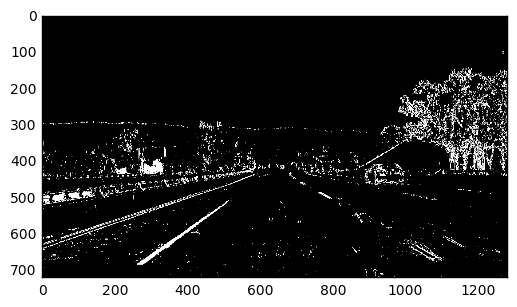

In [13]:
if is_debug_mode:
    img_straight_lines = test_image
#     img_straight_lines = mpimg.imread(test_img)
    img_stlines_filt = apply_gradx_color_filter(img_straight_lines)
    # plt.imshow(img_straight_lines)
    plt.imshow(img_stlines_filt, cmap='gray')

### 3. Undistort & Unwarp

In [14]:
def undistort_image(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [15]:
def warp_perspective(img, M):
    """
    `img` is the undistored image
    `M` is the perspective transform matrix
    """
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), 
                                      flags=cv2.INTER_LINEAR)
    return warped

#### Review unwarped image

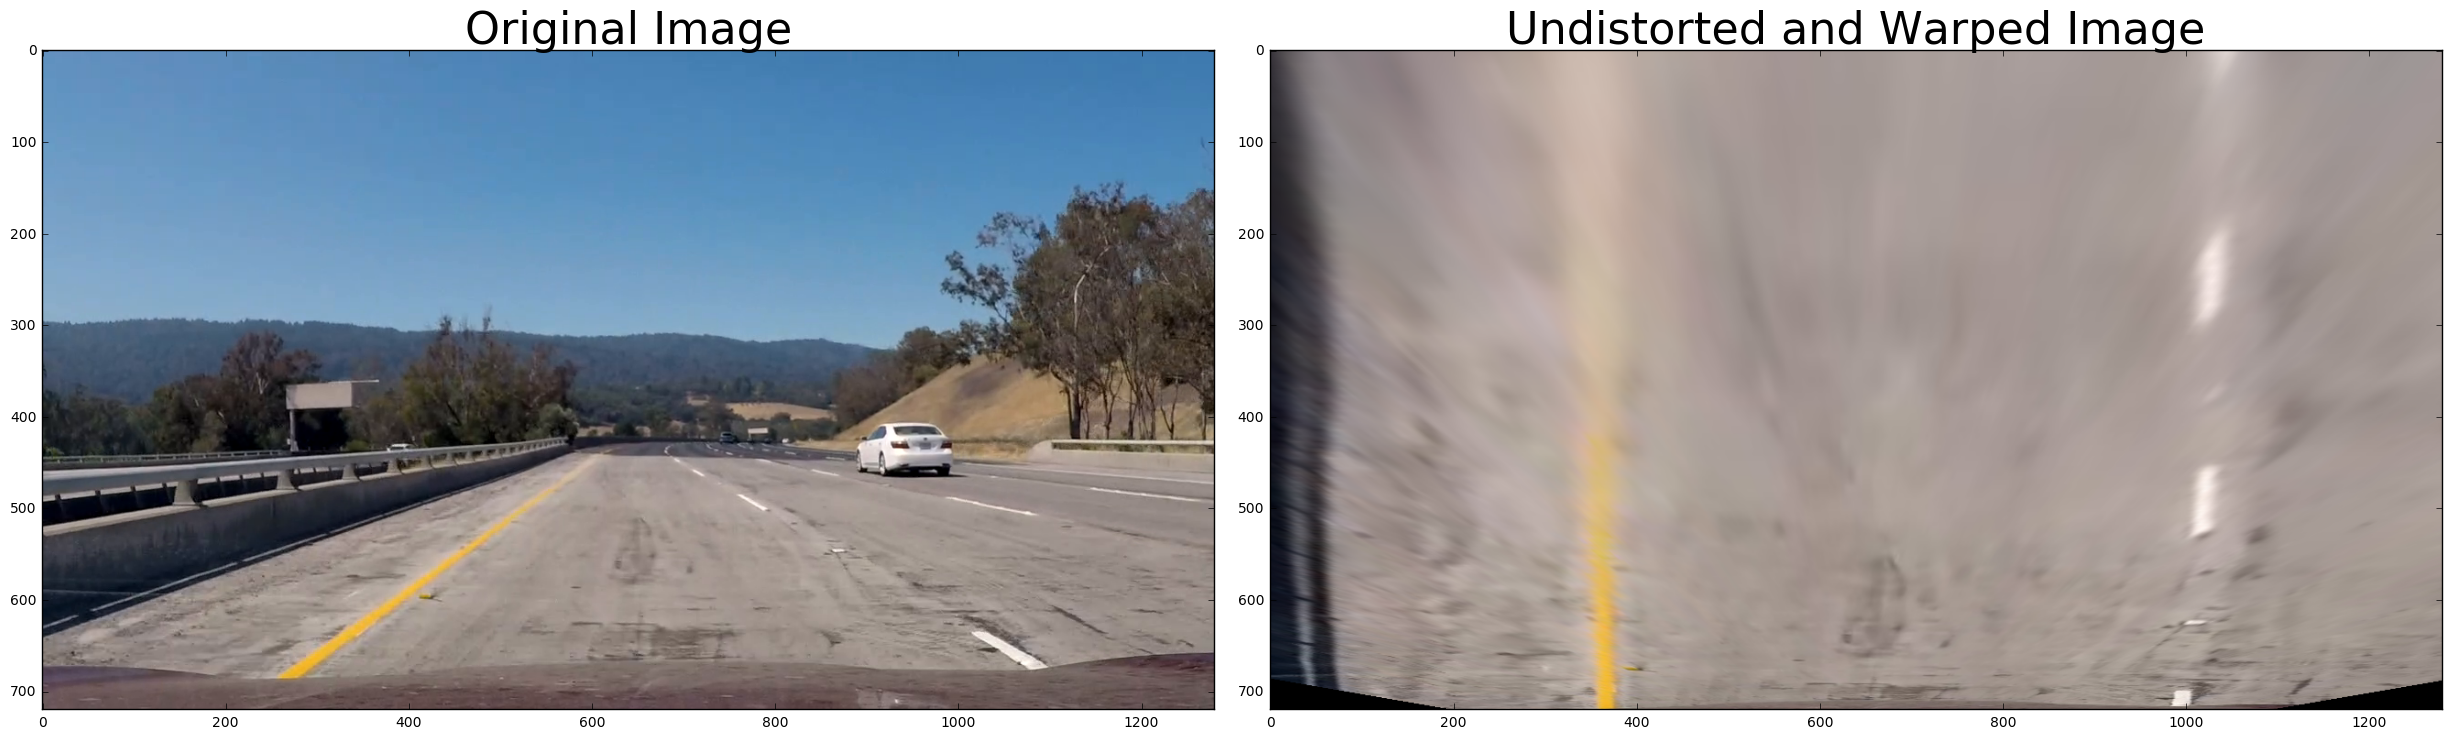

In [16]:
if is_debug_mode:
    img_undistort = undistort_image(img=img_straight_lines, mtx=mtx, dist=dist)
    img_unwarp = warp_perspective(img=img_undistort, M=M)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img_straight_lines)
    ax1.set_title('Original Image', fontsize=32)
    ax2.imshow(img_unwarp)
    ax2.set_title('Undistorted and Warped Image', fontsize=32)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Gradient, Color Filtering

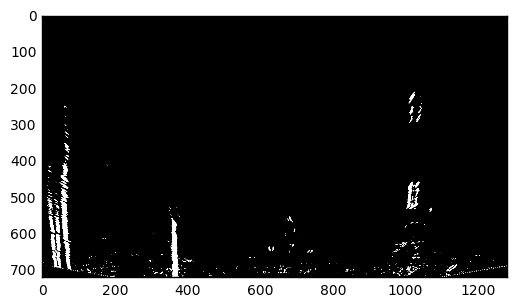

In [17]:
if is_debug_mode:
    img_unwarp_cfilt = apply_gradx_color_filter(img_unwarp)
    plt.imshow(img_unwarp_cfilt, cmap='gray')

### 5a. Find Lane Lines (Sliding Window)

In [48]:
def find_lane_pixels(binary_warped, nwindows=9, margin=100, min_pixels=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                              (win_xleft_high,win_y_high),
                      (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
                              (win_xright_high,win_y_high),
                      (0,255,0), 2)
        
        ### indIdentify the nonzero pixels in x and y within the window ###
        good_left_inds = np.where((nonzerox >= win_xleft_low) &
                                  (nonzerox < win_xleft_high) &
                                  (nonzeroy >= win_y_low) &
                                  (nonzeroy < win_y_high))[0]
        # list(zip(nonzerox[nz_left], nonzeroy[nz_left]))
        good_right_inds = np.where((nonzerox >= win_xright_low) &
                                  (nonzerox < win_xright_high) &
                                  (nonzeroy >= win_y_low) &
                                  (nonzeroy < win_y_high))[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > min_pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > min_pixels:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        
        if len(good_right_inds) > min_pixels:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))
            

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(img_shape, leftx, lefty, rightx, righty, order=2):
    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, order)
    right_fit = np.polyfit(righty, rightx, order)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = np.polyval(left_fit, ploty)
    right_fitx = np.polyval(right_fit, ploty)

    return left_fit, right_fit, left_fitx, right_fitx, ploty

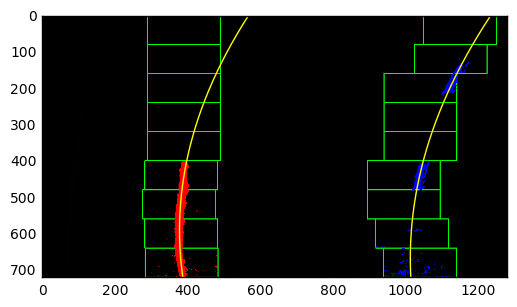

In [49]:
if is_debug_mode:
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img_unwarp_cfilt)
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(out_img.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.imshow(out_img)

### Pipeline to generate polynomial lane lines

In [50]:
def get_poly_lanes(img):
    # Apply Sobel Gradient filter, color filter
    img_filt = apply_gradx_color_filter(img)

    # Undistort and unwarp image
    img_undistort = undistort_image(img=img_filt, mtx=mtx, dist=dist)
    img_unwarp = warp_perspective(img=img_undistort, M=M)
    
    # Find lane pixels
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img_unwarp)
    
    # Fit polynomials lines to left, right lanes
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(out_img.shape, leftx, lefty, rightx, righty)

    return img_unwarp, left_fit, right_fit, left_fitx, right_fitx, ploty

In [51]:
def plot_lane_lines(img, left_x, right_x, y):
    for i in range(len(left_x)-1):
        cv2.line(img, (int(left_x[i]), int(y[i+1])), (int(left_x[i+1]), int(y[i+1])), color=(255, 0, 0), thickness=5)
        cv2.line(img, (int(right_x[i]), int(y[i+1])), (int(right_x[i+1]), int(y[i+1])), color=(255, 0, 0), thickness=5)

In [52]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [53]:
def add_lanes_poly(image):
    img_unwarp, left_fit, right_fit, left_fitx, right_fitx, ploty = get_poly_lanes(image)
    
    # create lanes poly
    pts = np.vstack([np.vstack([left_fitx, ploty]).astype(np.int32).T, 
                     np.vstack([right_fitx[::-1], ploty[::-1]]).astype(np.int32).T])
    lanes_poly = np.zeros([img_unwarp.shape[0], img_unwarp.shape[1], 3])
    lanes_img = cv2.fillPoly(lanes_poly,  [pts],  (255, 0, 0))
    
    # unwarp lanes perspective
    lanes_img_warp = warp_perspective(img=lanes_img, M=np.linalg.inv(M)).astype(np.uint8)
    
    
    return weighted_img(img=lanes_img_warp, initial_img=image, α=1.0, β=0.5)

#### Test pipeline

In [66]:
def get_image(file_name, time):
    vidcap = cv2.VideoCapture(file_name)
    for i in range(int(time*25)):
        flag, img = vidcap.read()
    return img

In [67]:
# img_orig = test_image #mpimg.imread("test_images/test6.jpg")
# img_orig = mpimg.imread("test_images/test5.jpg")
img_orig = get_image("project_video.mp4", time=24)
img_unwarp, left_fit, right_fit, left_fitx, right_fitx, ploty = get_poly_lanes(img_orig)
# plt.plot(left_fitx, ploty, color='red', linewidth=3, alpha=0.8)
# plt.plot(right_fitx, ploty, color='red', linewidth=3, alpha=0.8)
# plt.imshow(img_unwarp, cmap='gray')

In [68]:
pts = np.vstack([np.vstack([left_fitx, ploty]).astype(np.int32).T, 
                 np.vstack([right_fitx[::-1], ploty[::-1]]).astype(np.int32).T])
lanes_poly = np.zeros([img_unwarp.shape[0], img_unwarp.shape[1], 3])
lanes_img = cv2.fillPoly(lanes_poly,  [pts],  (255, 0, 0))

# Warp lanes and plot
lanes_img_warp = warp_perspective(img=lanes_img, M=np.linalg.inv(M)).astype(np.uint8)
# plt.imshow(lanes_img_warp)

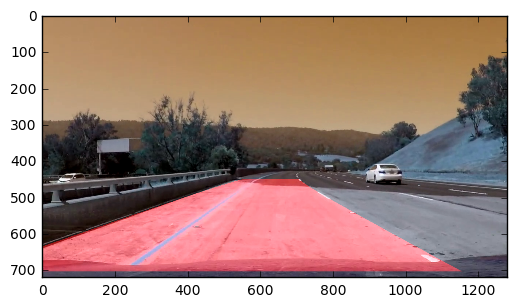

In [69]:
combined_img = weighted_img(img=lanes_img_warp, initial_img=img_orig, α=1.0, β=0.5)
plt.imshow(combined_img)

### Testing Video

In [21]:
from moviepy.editor import VideoFileClip
white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(add_lanes_poly)
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video project_video_out.mp4.
Moviepy - Writing video project_video_out.mp4



Moviepy - Done !
Moviepy - video ready project_video_out.mp4
Wall time: 3min 40s


In [41]:
test_image = clip1.get_frame(t=22.75)

In [28]:
np.mean(right_fitx - left_fitx)

628.12862092279181

In [29]:
left_fit[:]

array([ -4.11485513e-04,   6.11147408e-01,   1.79417300e+02])

In [30]:
test_image.shape

(720, 1280, 3)